## Importing libraries

In [48]:
import numpy as np
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize': [10, 7]}, font_scale=1.0)

## for processing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.model_selection import train_test_split

## For Model
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
from xgboost import XGBRegressor

## For Evaluation
from sklearn.metrics import mean_squared_log_error 


## Helper Function


In [2]:
#Loading Data function
def load_data(DATA_PATH,name):
    """Loading the data passing the data path and the name of file"""
    csv_path=os.path.join(DATA_PATH,name)
    return pd.read_pickle(csv_path)

# Profit  function
def calculate_profit_per_hour(row,taxes,registered_per_hour,casual_per_hour,maintenance_per_year):
    """
    Calculate the Profit
    """
    taxes=taxes/100
    maintenance_per_hour=maintenance_per_year/(365*24)
    profit=(row['casual']*casual_per_hour)+(row['registered']*registered_per_hour)
    profit_after_taxes=profit-(profit*taxes)
    total_profit=profit_after_taxes-maintenance_per_hour
    return total_profit

# extract date features
def extract_date_features(df):
    """Handling the date to get important features"""
    df['datetime'] = pd.to_datetime(df['datetime'],format='%Y-%m-%d %H:%M:%S',errors="coerce")
    df['year']= df['datetime'].dt.year
    df['month']= df['datetime'].dt.month_name()
    df['day_of_week'] = df['datetime'].dt.day_name()
    df['hour'] = df['datetime'].dt.hour

    return df

def is_ruch_hour(hour,lst):
    """Checking for rush hour"""
    return 1 if hour in lst else 0 


def is_school_day (month,lst):
    """Checking for if is a school day"""
    return 1 if month in lst else 0


# RMSLE function
def RMSLE(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

## Get the data

In [3]:
# Load the date
DATA_PATH=os.path.join('./dataset/')
df=load_data(DATA_PATH,"bikes.p")
df.head()

,datetime,season,holiday,workingday,weather,temp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,spring,0,0,clear,9.84,81,0.0,3,13,16
1,2011-01-01 01:00:00,spring,0,0,clear,9.02,80,0.0,8,32,40
2,2011-01-01 02:00:00,spring,0,0,clear,9.02,80,0.0,5,27,32
3,2011-01-01 03:00:00,spring,0,0,clear,9.84,75,0.0,3,10,13
4,2011-01-01 04:00:00,spring,0,0,clear,9.84,75,0.0,0,1,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  object 
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  object 
 5   temp        10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   casual      10886 non-null  int64  
 9   registered  10886 non-null  int64  
 10  count       10886 non-null  int64  
dtypes: float64(2), int64(6), object(3)
memory usage: 935.6+ KB


In [5]:
df.describe()

,holiday,workingday,temp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,0.028569,0.680875,20.23086,61.886460,12.799395,36.021955,155.552177,191.574132
std,0.166599,0.466159,7.79159,19.245033,8.164537,49.960477,151.039033,181.144454
min,0.000000,0.000000,0.82000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,13.94000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,0.000000,1.000000,20.50000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,0.000000,1.000000,26.24000,77.000000,16.997900,49.000000,222.000000,284.000000
max,1.000000,1.000000,41.00000,100.000000,56.996900,367.000000,886.000000,977.000000


In [6]:
df.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

There is no missing values on data, but there is a lot of zeros data, it can be nan?


In [7]:
df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

In [8]:
for col in [ 'season', 'holiday', 'workingday', 'weather']:
    print(f">>>>>>> {col.capitalize()} <<<<<<")
    print(df[col].unique())
    print("========================================================================")
    #df[col] = df[col].astype('int64')

>>>>>>> Season <<<<<<
['spring' 'summer' 'fall' 'winter']
>>>>>>> Holiday <<<<<<
[0 1]
>>>>>>> Workingday <<<<<<
[0 1]
>>>>>>> Weather <<<<<<
['clear' 'cloudy' 'light rain' 'heavy rain']


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  object 
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  object 
 5   temp        10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   casual      10886 non-null  int64  
 9   registered  10886 non-null  int64  
 10  count       10886 non-null  int64  
dtypes: float64(2), int64(6), object(3)
memory usage: 935.6+ KB


##  Explore the Data

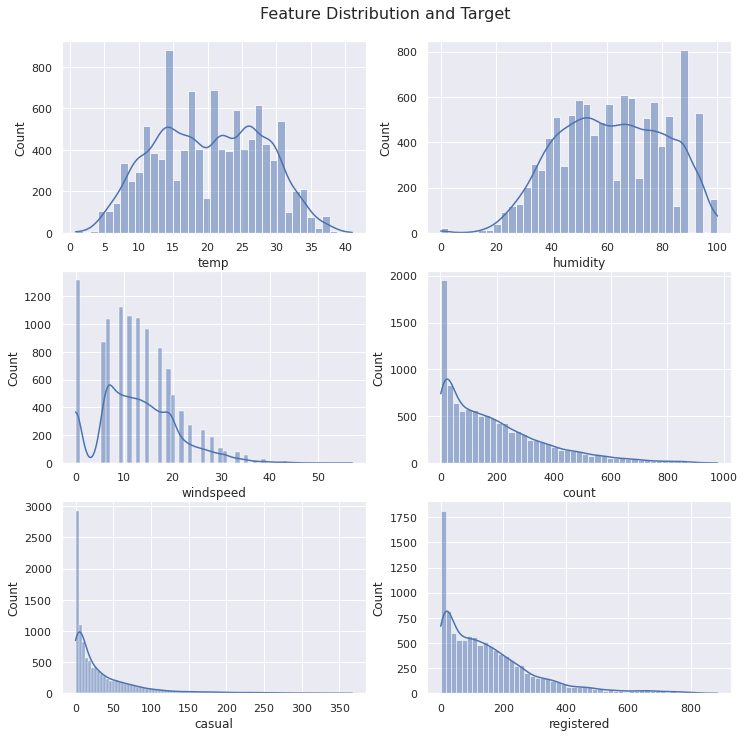

In [10]:
# create subplot contain 6 plots (2 plot for 3 rows)
fig, ax = plt.subplots(3,2, figsize=(12,12))

# set title for figure
fig.suptitle('Feature Distribution and Target', fontsize=16, y=0.92)

# draw histogram for feature and  best fit line.
sns.histplot(df.temp, ax=ax[0][0],kde=True)
sns.histplot(df.humidity, ax=ax[0][1],kde=True)
sns.histplot(df.windspeed, ax=ax[1][0],kde=True)
sns.histplot(df['count'], ax=ax[1][1],kde=True)
sns.histplot(df.casual, ax=ax[2][0],kde=True)
sns.histplot(df.registered, ax=ax[2][1],kde=True)
plt.show()

df.columns

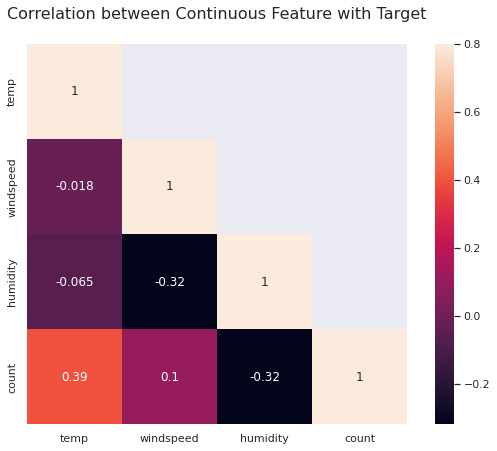

In [11]:
corrMatt=df[['temp','windspeed','humidity','count']].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
g = sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True, )
g.set_title("Correlation between Continuous Feature with Target", fontsize=16, y=1.05)
plt.show()


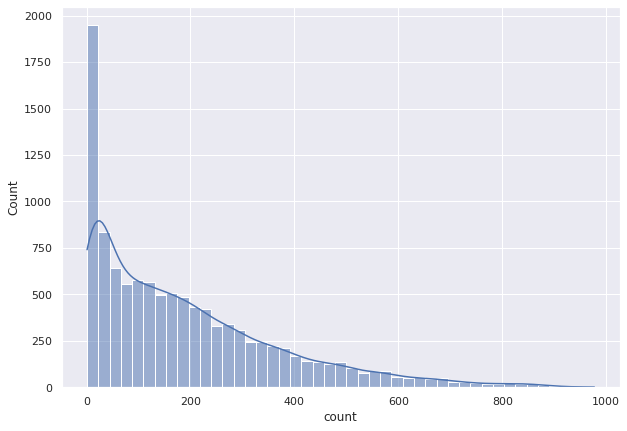

In [12]:
sns.histplot(df['count'],kde=True);


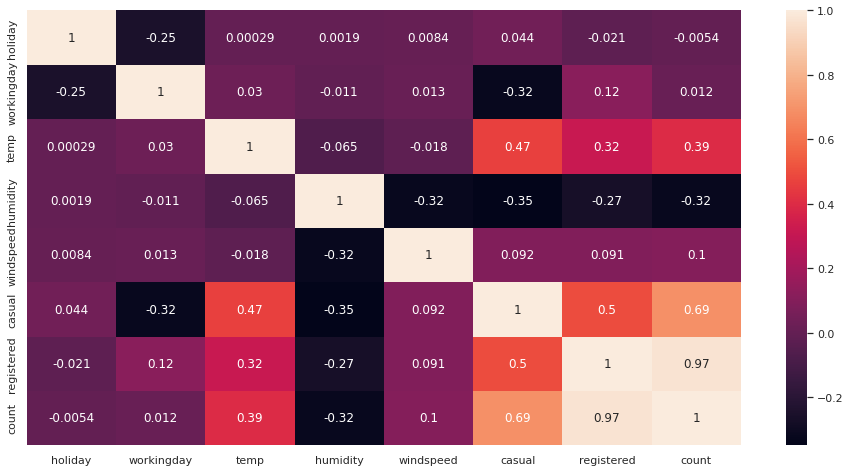

In [13]:
plt.figure(figsize=(16,8))
sns.heatmap(df.corr(), annot=True)
plt.show()

## Prepare the Data 


### Handling Numerical Attributes

In [14]:
Num_Features=['temp','windspeed','humidity','casual','registered','count']

In [15]:
Num_data=df[Num_Features]

In [16]:
Num_data.describe()

,temp,windspeed,humidity,casual,registered,count
count,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,20.23086,12.799395,61.886460,36.021955,155.552177,191.574132
std,7.79159,8.164537,19.245033,49.960477,151.039033,181.144454
min,0.82000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,13.94000,7.001500,47.000000,4.000000,36.000000,42.000000
50%,20.50000,12.998000,62.000000,17.000000,118.000000,145.000000
75%,26.24000,16.997900,77.000000,49.000000,222.000000,284.000000
max,41.00000,56.996900,100.000000,367.000000,886.000000,977.000000


In [17]:
from datasist.structdata import detect_outliers

In [18]:
x=detect_outliers(Num_data,0,Num_data.columns)

In [19]:
df_without_outliers=df[~df.index.isin(x)]
df_without_outliers=df_without_outliers.reset_index().drop(columns='index')

In [20]:
Num_data_without_outliers=df_without_outliers[Num_Features]

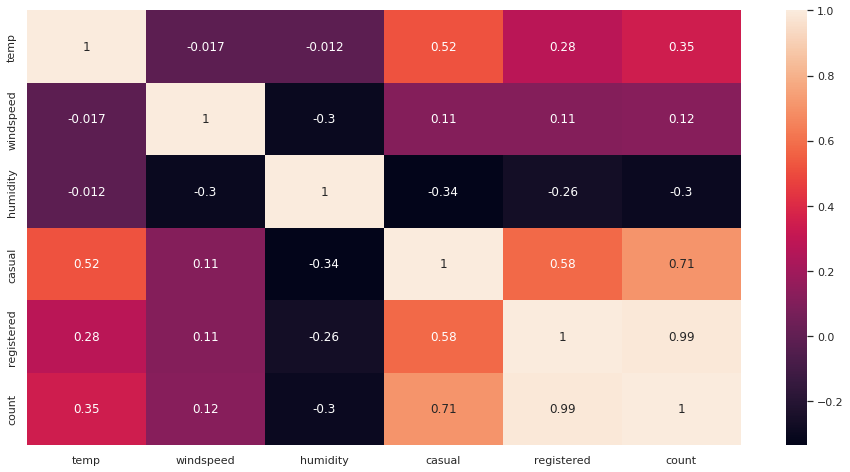

In [21]:
plt.figure(figsize=(16,8))
sns.heatmap(Num_data_without_outliers.corr(), annot=True)
plt.show()

### Handling Categorical Attributes

In [22]:
df_without_outliers=extract_date_features(df_without_outliers)


In [23]:
Cat_Features=['season', 'holiday', 'workingday', 'weather','year','month', 'day_of_week', 'hour']

In [24]:
Cat_data=df_without_outliers[Cat_Features]

In [25]:
Cat_data.head()

,season,holiday,workingday,weather,year,month,day_of_week,hour
0,spring,0,0,clear,2011,January,Saturday,0
1,spring,0,0,clear,2011,January,Saturday,1
2,spring,0,0,clear,2011,January,Saturday,2
3,spring,0,0,clear,2011,January,Saturday,3
4,spring,0,0,clear,2011,January,Saturday,4


In [26]:
for i in Cat_data.columns:
    Cat_data[i]=Cat_data[i].astype('category')

/home/mo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [27]:
ohe = OneHotEncoder(sparse=False)
ohe_cat=ohe.fit_transform(Cat_data[['day_of_week','season','weather','month','hour']])

In [28]:
ohe_catDF=pd.DataFrame(ohe_cat,columns=ohe.get_feature_names_out())
ohe_catDF

,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,season_fall,season_spring,season_summer,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9513,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9514,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9515,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9516,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [29]:
Cat_data=Cat_data.drop(columns=['day_of_week','season','weather','month','hour'])


In [30]:
lab=LabelEncoder()
for col in ['holiday','workingday','year']:
    Cat_data[col]=lab.fit_transform(Cat_data[col])


In [31]:
CatDF=pd.concat([ohe_catDF,Cat_data],axis=1)

In [32]:
full_Df=pd.concat([CatDF,Num_data_without_outliers],axis=1)

In [33]:
full_Df.columns

Index(['day_of_week_Friday', 'day_of_week_Monday', 'day_of_week_Saturday',
       'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Tuesday',
       'day_of_week_Wednesday', 'season_fall', 'season_spring',
       'season_summer', 'season_winter', 'weather_clear', 'weather_cloudy',
       'weather_heavy rain', 'weather_light rain', 'month_April',
       'month_August', 'month_December', 'month_February', 'month_January',
       'month_July', 'month_June', 'month_March', 'month_May',
       'month_November', 'month_October', 'month_September', 'hour_0',
       'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
       'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22', 'hour_23', 'holiday', 'workingday',
       'year', 'temp', 'windspeed', 'humidity', 'casual', 'registered',
       'count'],
      dtype='object')

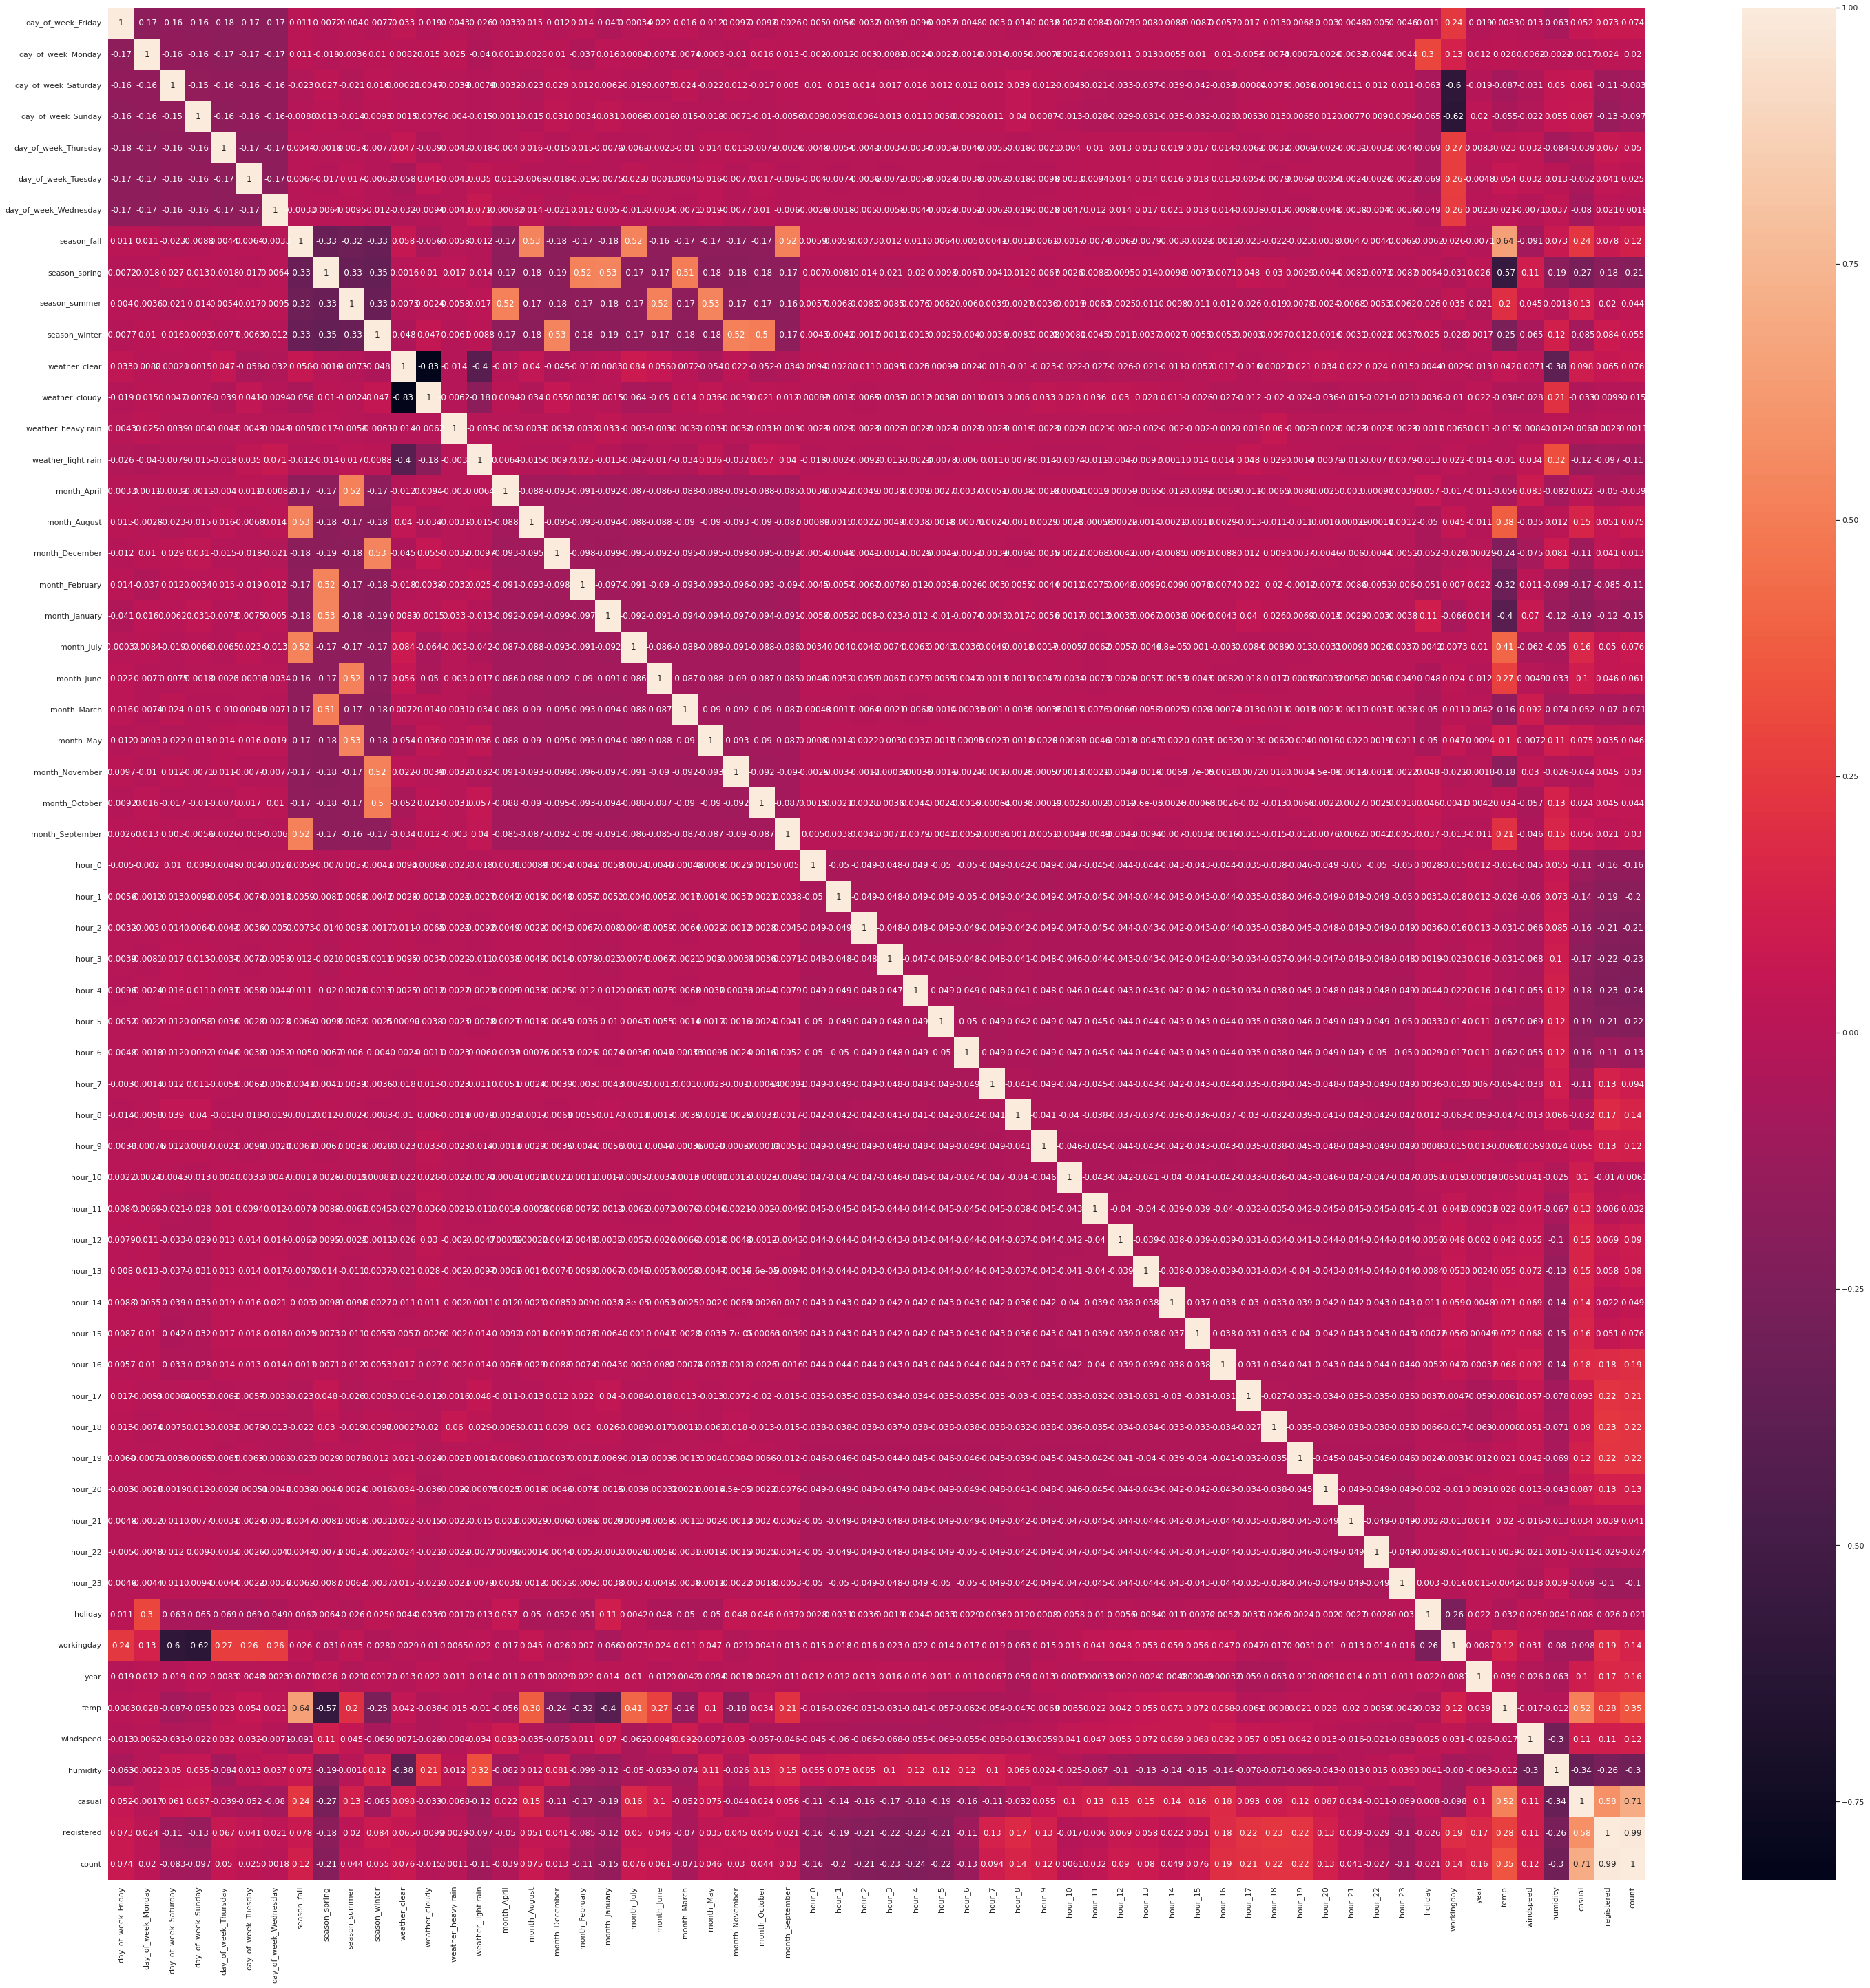

In [34]:
corr_matrix=full_Df.corr()

plt.figure(figsize=(50,50))
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [35]:
full_Df.to_pickle("./dataset/full_Df_v1")

In [36]:
full_Df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9518 entries, 0 to 9517
Data columns (total 60 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   day_of_week_Friday     9518 non-null   float64
 1   day_of_week_Monday     9518 non-null   float64
 2   day_of_week_Saturday   9518 non-null   float64
 3   day_of_week_Sunday     9518 non-null   float64
 4   day_of_week_Thursday   9518 non-null   float64
 5   day_of_week_Tuesday    9518 non-null   float64
 6   day_of_week_Wednesday  9518 non-null   float64
 7   season_fall            9518 non-null   float64
 8   season_spring          9518 non-null   float64
 9   season_summer          9518 non-null   float64
 10  season_winter          9518 non-null   float64
 11  weather_clear          9518 non-null   float64
 12  weather_cloudy         9518 non-null   float64
 13  weather_heavy rain     9518 non-null   float64
 14  weather_light rain     9518 non-null   float64
 15  mont

In [37]:
y_log_count = np.log1p(full_Df['count'])
y_log_casual = np.log1p(full_Df['casual'])
y_log_registered = np.log1p(full_Df['registered'])

X_train, X_test, y_train, y_test= train_test_split(full_Df.drop(columns=[ 'count','registered','casual']),y_log_count, test_size=.2, random_state=42)
X_train_casual, X_test_casual, y_train_casual, y_test_casual= train_test_split(full_Df.drop(columns=[ 'count','registered','casual']),y_log_casual, test_size=.2, random_state=42)
X_train_registered, X_test_registered, y_train_registered, y_test_registered= train_test_split(full_Df.drop(columns=[ 'count','registered','casual']),y_log_registered, test_size=.2, random_state=42)


In [39]:
scaler=StandardScaler()
X_train[['temp', 'windspeed', 'humidity']]=scaler.fit_transform(X_train[['temp', 'windspeed', 'humidity']])
X_train_casual[['temp', 'windspeed', 'humidity']]=scaler.fit_transform(X_train_casual[['temp', 'windspeed', 'humidity']])
X_train_registered[['temp', 'windspeed', 'humidity']]=scaler.fit_transform(X_train_registered[['temp', 'windspeed', 'humidity']])
X_test[['temp', 'windspeed', 'humidity']]=scaler.transform(X_test[['temp', 'windspeed', 'humidity']])
X_test_casual[['temp', 'windspeed', 'humidity']]=scaler.transform(X_test_casual[['temp', 'windspeed', 'humidity']])
X_test_registered[['temp', 'windspeed', 'humidity']]=scaler.transform(X_test_registered[['temp', 'windspeed', 'humidity']])

# Find Model Regression

In [51]:
import time
models={
    'SVM':SVR(),
    "RF":RandomForestRegressor(random_state=42),
    "XTR":ExtraTreesRegressor(random_state=42),
    "XGBR":XGBRegressor(random_state=42)}

for name,model in models.items():
    start_time = time.time()
    print(f'Using model: {name}')
    model.fit(X_train,y_train)
    print(f"Training Score: {model.score(X_train,y_train)}")
    print(f"Test Score: {model.score(X_test,y_test)}")

    y_pred_test=model.predict(X_test)
    print(f"RMSLE : {RMSLE(np.exp(y_pred_test),np.exp(y_test))}")
    End_time = time.time()
    print(f"Duration : {End_time-start_time}")
    print("======================================================")
    


Using model: SVM
Training Score: 0.9599811768427122
Test Score: 0.936037599780321
RMSLE : 0.3188249815414623
Duration : 8.484748363494873
Using model: RF
Training Score: 0.9917237064317486
Test Score: 0.9352056025662576
RMSLE : 0.3240418636752107
Duration : 4.991341590881348
Using model: XTR
Training Score: 0.9999966737056218
Test Score: 0.9320494976710253
RMSLE : 0.332020429349338
Duration : 5.533251047134399
Using model: XGBR
Training Score: 0.9835917208891737
Test Score: 0.9443739333892974
RMSLE : 0.30007883668941027
Duration : 0.43556928634643555


**We choose XGBRegressor for best Score and less Error and much Faster**

## XGBoost for Regression Model

In [58]:
# Define the grid of hyperparameters to search

params = { 'max_depth': [3, 5, 6, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.3, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [100, 500, 1000]
         }
reg = RandomizedSearchCV(estimator=XGBRegressor(),param_distributions=params,
                         scoring='neg_mean_squared_log_error',n_iter=35,cv=5,
                         verbose=1,return_train_score = True,random_state=42)
reg.fit(X_train, y_train)
print("Best parameters:", reg.best_params_)
print("Lowest RMSE: ", (-reg.best_score_)**(1/2.0))

Fitting 5 folds for each of 35 candidates, totalling 175 fits
Best parameters: {'subsample': 0.8999999999999999, 'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.6000000000000001, 'colsample_bylevel': 0.4}
Lowest RMSE:  0.08246537928699083


In [69]:
y_pred_test=reg.predict(X_test)
y_pred_train=reg.predict(X_train)


In [70]:
print(f"RMSLE : {RMSLE(np.exp(y_pred_test),np.exp(y_test))}")

RMSLE : 0.29500884109489134


In [71]:
print(f"RMSLE : {RMSLE(np.exp(y_pred_train),np.exp(y_train))}")

RMSLE : 0.24470878024922996


In [75]:
import pickle
pickle.dump(reg, open('./models/reg.pkl','wb'))# saving the trained model

In [76]:
reg = pickle.load(open('./models/reg.pkl', 'rb')) # loading the trained model
